In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

plt.style.use('seaborn-v0_8')

ROOT = Path.cwd()
DATA_DIR = ROOT / 'datasource'
IMG_DIR = DATA_DIR / 'faces_dataset'
LABELS_CSV = DATA_DIR / 'labels_export.csv'

DATA_DIR, IMG_DIR, LABELS_CSV

(WindowsPath('c:/Users/Admin/OneDrive/Documentos/github.com/artemisaix/sprint17/sprint_17_vision_artificial/datasource'),
 WindowsPath('c:/Users/Admin/OneDrive/Documentos/github.com/artemisaix/sprint17/sprint_17_vision_artificial/datasource/faces_dataset'),
 WindowsPath('c:/Users/Admin/OneDrive/Documentos/github.com/artemisaix/sprint17/sprint_17_vision_artificial/datasource/labels_export.csv'))

In [2]:
# Cargar datos
assert LABELS_CSV.exists(), f"No se encuentra el CSV: {LABELS_CSV}"
assert IMG_DIR.exists(), f"No se encuentra la carpeta de imágenes: {IMG_DIR}"

df = pd.read_csv(LABELS_CSV)

# Normalizamos columnas esperadas: file_name, real_age
expected_cols = {"file_name", "real_age"}
if set(df.columns) != expected_cols:
    # Intento trivial de adaptar posibles encabezados distintos
    df.columns = [c.strip().lower() for c in df.columns]
    assert set(df.columns) >= expected_cols, f"El CSV debe tener columnas {expected_cols}, actuales: {df.columns.tolist()}"
    df = df[["file_name", "real_age"]]

# Añadir ruta absoluta de imagen
df["img_path"] = df["file_name"].apply(lambda x: str(IMG_DIR / x))

# Validación de existencia de archivos
df["exists"] = df["img_path"].apply(lambda p: Path(p).exists())
missing = (~df["exists"]).sum()
print(f"Filas totales: {len(df):,}")
print(f"Imágenes faltantes: {missing:,}")
df.head()

Filas totales: 7,591
Imágenes faltantes: 0


,file_name,real_age,img_path,exists
0,000000.jpg,4,c:\Users\Admin\OneDrive\Documentos\github.com\...,True
1,000001.jpg,18,c:\Users\Admin\OneDrive\Documentos\github.com\...,True
2,000002.jpg,80,c:\Users\Admin\OneDrive\Documentos\github.com\...,True
3,000003.jpg,50,c:\Users\Admin\OneDrive\Documentos\github.com\...,True
4,000004.jpg,17,c:\Users\Admin\OneDrive\Documentos\github.com\...,True


El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

Registros válidos: 7,591
Rango de edades: 1–100
Archivos únicos: 7,591


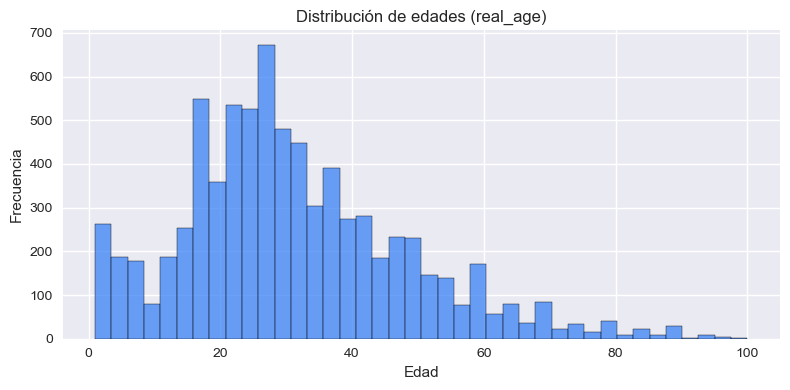

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [3]:
# EDA: tamaño y distribución de edades

# Asegurar tipos
_df = df.copy()
_df['real_age'] = pd.to_numeric(_df['real_age'], errors='coerce')
_df = _df.dropna(subset=['real_age'])
_df['real_age'] = _df['real_age'].astype(int)

n_total = len(_df)
age_min, age_max = _df['real_age'].min(), _df['real_age'].max()
unique_files = _df['file_name'].nunique()
print(f"Registros válidos: {n_total:,}")
print(f"Rango de edades: {age_min}–{age_max}")
print(f"Archivos únicos: {unique_files:,}")

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.histplot(_df['real_age'], bins=40, kde=False, ax=ax, color='#3b82f6')
ax.set_title('Distribución de edades (real_age)')
ax.set_xlabel('Edad')
ax.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

_df['real_age'].describe()

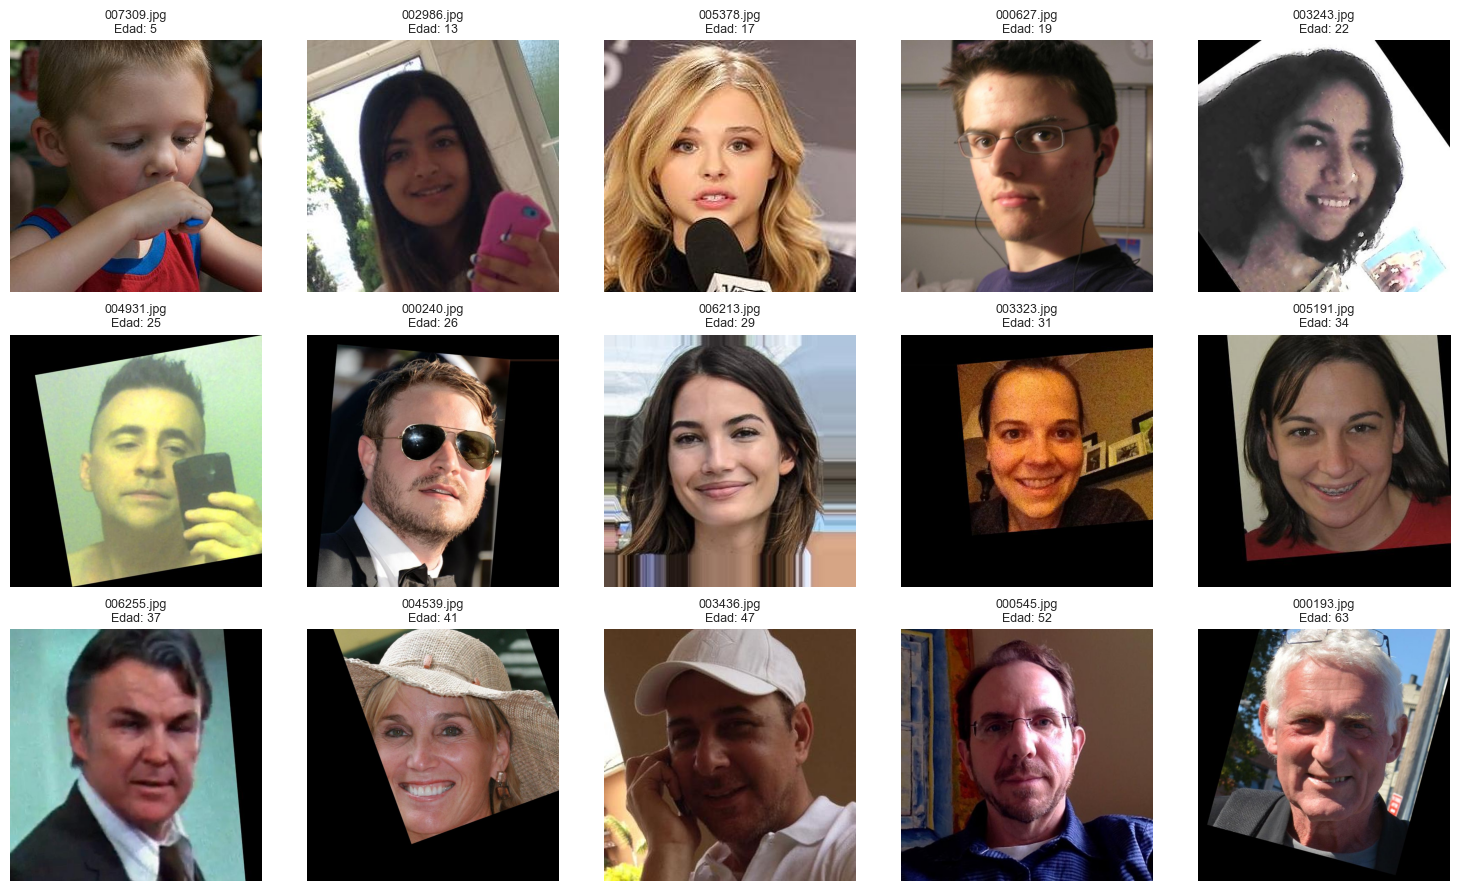

In [4]:
# Muestra de 15 imágenes para distintas edades

from math import ceil

# Elegimos edades representativas usando cuantiles para cubrir todo el rango
quantiles = np.linspace(0.05, 0.95, 15)
edges = _df['real_age'].quantile(quantiles).astype(int).tolist()

samples = []
for age in edges:
    subset = _df[_df['real_age'] == age]
    if subset.empty:
        # si no hay exacta, aproximamos por edad más cercana
        idx = (_df['real_age'] - age).abs().idxmin()
        samples.append(_df.loc[idx])
    else:
        samples.append(subset.sample(1, random_state=42).iloc[0])

n = len(samples)
cols = 5
rows = ceil(n/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for ax, row in zip(axes, samples):
    p = Path(row['img_path'])
    try:
        img = Image.open(p).convert('RGB')
        ax.imshow(img)
        ax.set_title(f"{row['file_name']}\nEdad: {row['real_age']}", fontsize=9)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f"Error\n{p.name}", ha='center', va='center')
        ax.axis('off')

# ejes sobrantes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Conclusiones

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí

    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    #  coloca tu código aquí

    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

## Conclusiones

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo